# Direct problem: modeling pheromone propagation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import os
import time

import pherosensor

from pheromone_dispersion.geom import MeshRect2D
from pheromone_dispersion.diffusion_tensor import DiffusionTensor
from pheromone_dispersion.velocity import Velocity
from pheromone_dispersion.source_term import Source
from pheromone_dispersion.convection_diffusion_2D import DiffusionConvectionReaction2DEquation

from utils.plot_env_param import plot_velocity_field, plot_diffusion_tensor
from utils.plot_colormap import plot_colormap, plot_colormap_all_timestep
from utils.generate_gif import generate_gif

In [2]:
path = os.getcwd()
path_data = path + '/data'
path_output = path + '/output'
if not os.path.isdir(Path(path_output)):
    os.makedirs(Path(path_output))
path_plot = path_output + '/plot'
if not os.path.isdir(Path(path_plot)):
    os.makedirs(Path(path_plot))

This notebook aims at presenting the Partial Differential Equations (PDE) used to model the pheromone propagation in the atmosphere, the solvers implemented in the module `pheromone_dispersion` and the different submodules on which the solvers are based.

In a first section, the 2D PDE pheromone propagation model is presented. \
Then, the different submodules are presented and illustrated over a simple but representative case.  \
At last but not at least, the numerical solvers of the PDE model are presented and used to model the pheromone propagation in this test case. 

bibliography: ../paper/paper.bib

# Pheromone propagation model

The most classical model to simulate propagation of chemical specie in the atmosphere is a 3D Chemical-Transport Model (CTM). The CTM are obtained from the reactive Navier-Stokes equations by using especially the dilution hypothesis. This hypothesis consists in decoupling the dynamic of the atmosphere and the dynamic of the concentration of the chemical specie that is present is very small proportion and assumed chemically passive. As consequence, dynamical field such as the wind or the diffusion coefficients can be computed separately and given as parameters of the CTM.\
In the present context, the following 2D depth-integrated CTM, referred as the pheromone propagation model below, is used to model the total concentration of pheromone over the depth of the layer $c(x,y,t)$ [$g.m^{-2}$] on a domain $\Omega\in\mathbb{R}^2$ and during a time window $[0;T]$.
$$
\begin{equation}
    \frac{\partial c}{\partial t}-\nabla\cdot(\mathbf{K}\nabla c)+\nabla\cdot(\vec{u}c)+\tau_{loss}c=s~\forall (x,y,t)\in\Omega\times[0;T]
\end{equation}
$$

The coefficient $\mathbf{K}(x,y,t)$ [$m^2.s^{-1}$] is the diffusion coefficient. This coefficient results from modelling the turbulent diffusion at an unresolved scale (classically, scale smaller than the scale of the numerical grid) using the K theory.\
As mentioned above, in CTM, the wind velocity field $\vec{u}(x,y,t)=(u(x,y,t),v(x,y,t))$ [$m.s^{-1}$] is given as parameter. For example, $\vec{u}$ can be computed using a large meteorological model and then, taken as input data in the present CTM.\
The loss coefficient $\tau_{loss}(x,y,t)$ [$s^{-1}$] is the coefficient resulting from the loss of pheromone due to vertical phenomena. This includes the deposition and settling of the pheromone on the ground and the vertical diffusion that will spread the pheromone out of the layer of interest. Let us note that the loss coefficient $\tau_{loss}$ depends on the vegetation presents on the ground and on the stability of the atmosphere.\
The source term $s(x,y,t)$ [$g.m^{-2}.s^{-1}$] of the pheromone propagation model is the quantity of pheromone emitted by the insects per second. In the context of the PheroSensor project, the source term $s$ is the quantity to infer to deduce the localization of the insects. This inference is the subject of the package `source_localization` presented in the notebook on [pheromone emission inference and source localization](./pheromone_emission_inference_and_source_localization.ipynb).

The pheromone propagation model is closed by the following initial and boundary conditions:

 - a null initial condition $c(x,y,t=0)=0~\forall (x,y)\in\Omega$,
 - a null diffusive flux $\mathbf{K}\nabla c\cdot\vec{n}=0$ $\forall (x,y)\in\partial\Omega$,
 - a null entering convective flux $\vec{u}c\cdot\vec{n}=0$ $\forall (x,y)\in\partial\Omega\cap \{(x,y)|\vec{u}(x,y,t)\cdot\vec{n}<0\}~\forall t\in]0;T]$ with $\vec{n}$ the outgoing normal vector.

The pheromone propagation model is solved using implicit and semi-implicit upwind finite volume schemes implemented. More details can be found in the notebooks located in the folder `./test_numerical_scheme/` that introduce and test the numerial scheme, including convergence, and the solvers.

More details on this model and its derivation can be found in [Malou et al (2024)](https://hal.science/hal-04572831/).

# Construction of the solver of the pheromone propagation model

## Specifying the geometry using the `geom` submodule 

For now, the numerical solver of the pheromone propagation model has been implemented for a rectangular domain $\Omega=[0;L_x]\times[0;L_y]$.
Moreover, the mesh is supposed to be cartesian (rectangular cells) with constant space steps $\Delta x$ and $\Delta y$. \
Such geometry can be generated as an object of the `MeshRect2D` class of the `geom` [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/pheromone_dispersion/geom.py).

In [3]:
Lx = 30 # the length along the x-axis
Ly = 40 # the length along the y-axis
Delta_x = 0.5 # the space step along the x-axis
Delta_y = 0.5 # the space step along the y-axis
T_final = 20 # the final time of the simulation
msh = MeshRect2D(Lx, Ly, Delta_x, Delta_y, T_final)

Once the geometry is initialized, it remains to compute time step $\Delta t$ and the resulting array containing the time point. 
The time step is chosen especially to satisfy numerical stability conditions depending on the chosen time discretization (see below).\
In case of a implicit time discretization, the time step should be given by the user as the numerical scheme is unconditionnally stable. To do so, the user can use the `calc_dt_implicit_solver` method of the `MeshRect2D` class.\
In case of a semi-implicite or explicite time discretization, the user can use the `calc_dt_explicit_solver` method of the `MeshRect2D` class to compute a time step that satisfies the CFL condition depending on the wind field (see below). 

In [4]:
msh.calc_dt_implicit_solver(.1) 

## Specifying the wind velocity field using the `velocity` submodule 

As mentionned previously, the wind velocity field $\vec{u}=(u,v)$ has to be given as parameter of the pheromone propagation model.\
The wind field is here contained in an object of the `Velocity` class of the `velocity` [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/pheromone_dispersion/velocity.py). As the solvers are based on the finite volume method (see more details in [this notebook](./test_numerical_scheme/test_advection_operator.ipynb)), the velocity field should be given at both the vertical and horizontal interfaces of the cells of the mesh. One can provide stationnary wind field. Otherwise, the time array should be specified and between two time points contained in this array, the wind field will be linearly interpolated.\
Thus, the user should provide arrays containing the wind field at the vertical interface and at the horizontal interface that are resp. of shape (nb cell in y axis, nb cell in x axis + 1, 2) and (nb cell in y axis + 1, nb cell in x axis, 2) if the wind field is stationnary, and of shape (nb time point, nb cell in y axis, nb cell in x axis + 1, 2) and (nb time point, nb cell in y axis + 1, nb cell in x axis, 2) otherwise.     

In [5]:
U_vi = np.load(Path(path_data) / f'U_vi.npy')
U_hi = np.load(Path(path_data) / f'U_hi.npy')
U = Velocity(msh,U_vi, U_hi)

The `Velocity` class also contains useful attributes and methods to manipulate the wind field. 
For instance, the attributes `at_vertical_interface` and `at_horizontal_interface` contain the velocity field at resp. the vertical and horizontal interfaces of the mesh's cells at the current time, and the method `at_current_time` enables to update all the attributes at the time given as input of the method.\
Moreover, the wind velocity field can be plotted at the current time using the `plot_velocity_field` [method](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/utils/plot_env_param.py) of the `utils` module.

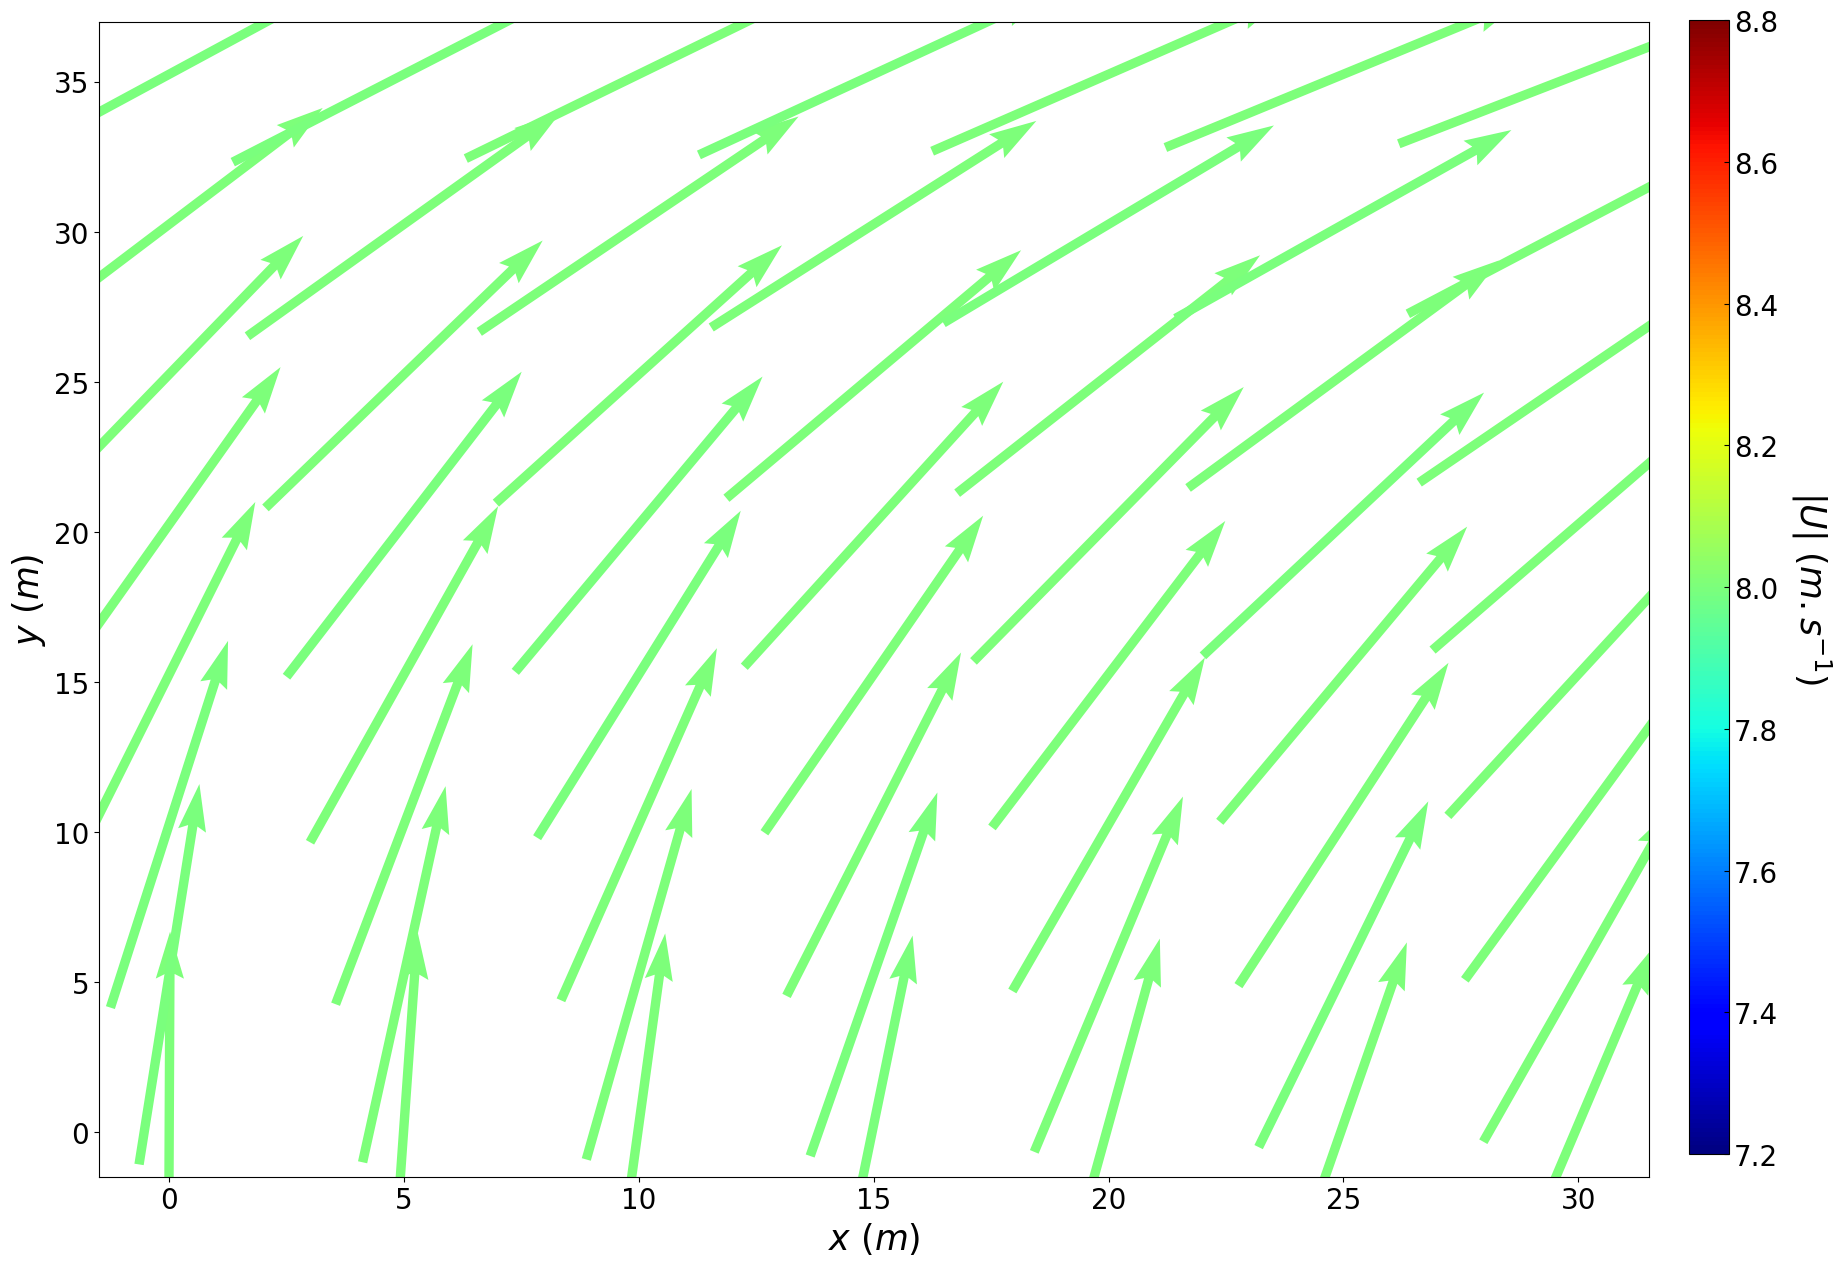

In [6]:
plot_velocity_field(msh,U)

The `velocity` submodule also containes a `velocity_field_from_meteo_data` method that can be used to generate an object of the `Velocity` class from meteorological data contained in a .csv file whose path and name are given as input.\
This method is implemented for meteorological data in the format of the data provided by the AROME model of MeteoFrance. However, it can easily be adapted for other format.\
This method computes the wind field on each cell interfaces by linear interpolation of the data potentially located on a irregular grid. 

## Specifying the diffusion tensor using the `diffusion_tensor` submodule 

The diffusion tensor is here contained in an object of the `DiffusionTensor` class of the `diffusion_tensor` [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/pheromone_dispersion/diffusion_tensor.py).

In the present case, we suppose that the diffusion tensor is given by a diffusion coefficient $K_u$ in the wind direction and a diffusion coefficient $K_{u^\perp}$ in the crosswind direction.\
Hence, the anistropic diffusion tensor is given by $\mathbf{K} = R(U)diag(K_u,K_{u^\perp})R(U)^T$ with $R(U)$ the rotation matrice of angle $\theta$ between the wind field and the cartesian frame. By the definition of the rotation matrice, the diffusion tensor can be rewritten $\mathbf{K} = K_{u^\perp}Id + (K_u-K_{u^\perp})\frac{UU^T}{\|U\|^2}$.\
Let us note that, in general, the crosswind diffusion coefficient $K_{u^\perp}$ is much larger that the wind diffusion coefficient.

Thus, the user should provide an object of the class `velocity` and the "in the wind direction" and the cross-wind diffusion coefficients to instanciate an object of the class `diffusion_tensor`. 

*For now, the case of a non-diagonal* $\mathbf{K}$ *has not been implemented. Therefore, we will take* $K_u=K_{u^\perp}$.

In [7]:
K = DiffusionTensor(U, 10., 10.)

As the numerical scheme is a finite volume scheme (see more details in [this notebook](./test_numerical_scheme/test_diffusion_operator.ipynb)) and similarly to the class `Velocity`, the `DiffusionTensor` class contains the attributes `at_vertical_interface` and `at_horizontal_interface` contain the diffusion tensor at resp. the vertical and horizontal interfaces of the mesh's cells at the current time, and the method `at_current_time` enables to update all the attributes at the time given as input of the method.

Moreover, the user can plot the diffusion tensor maps at the current time using the `plot_diffusion_tensor` [method](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/utils/plot_env_param.py) of the module `utils`

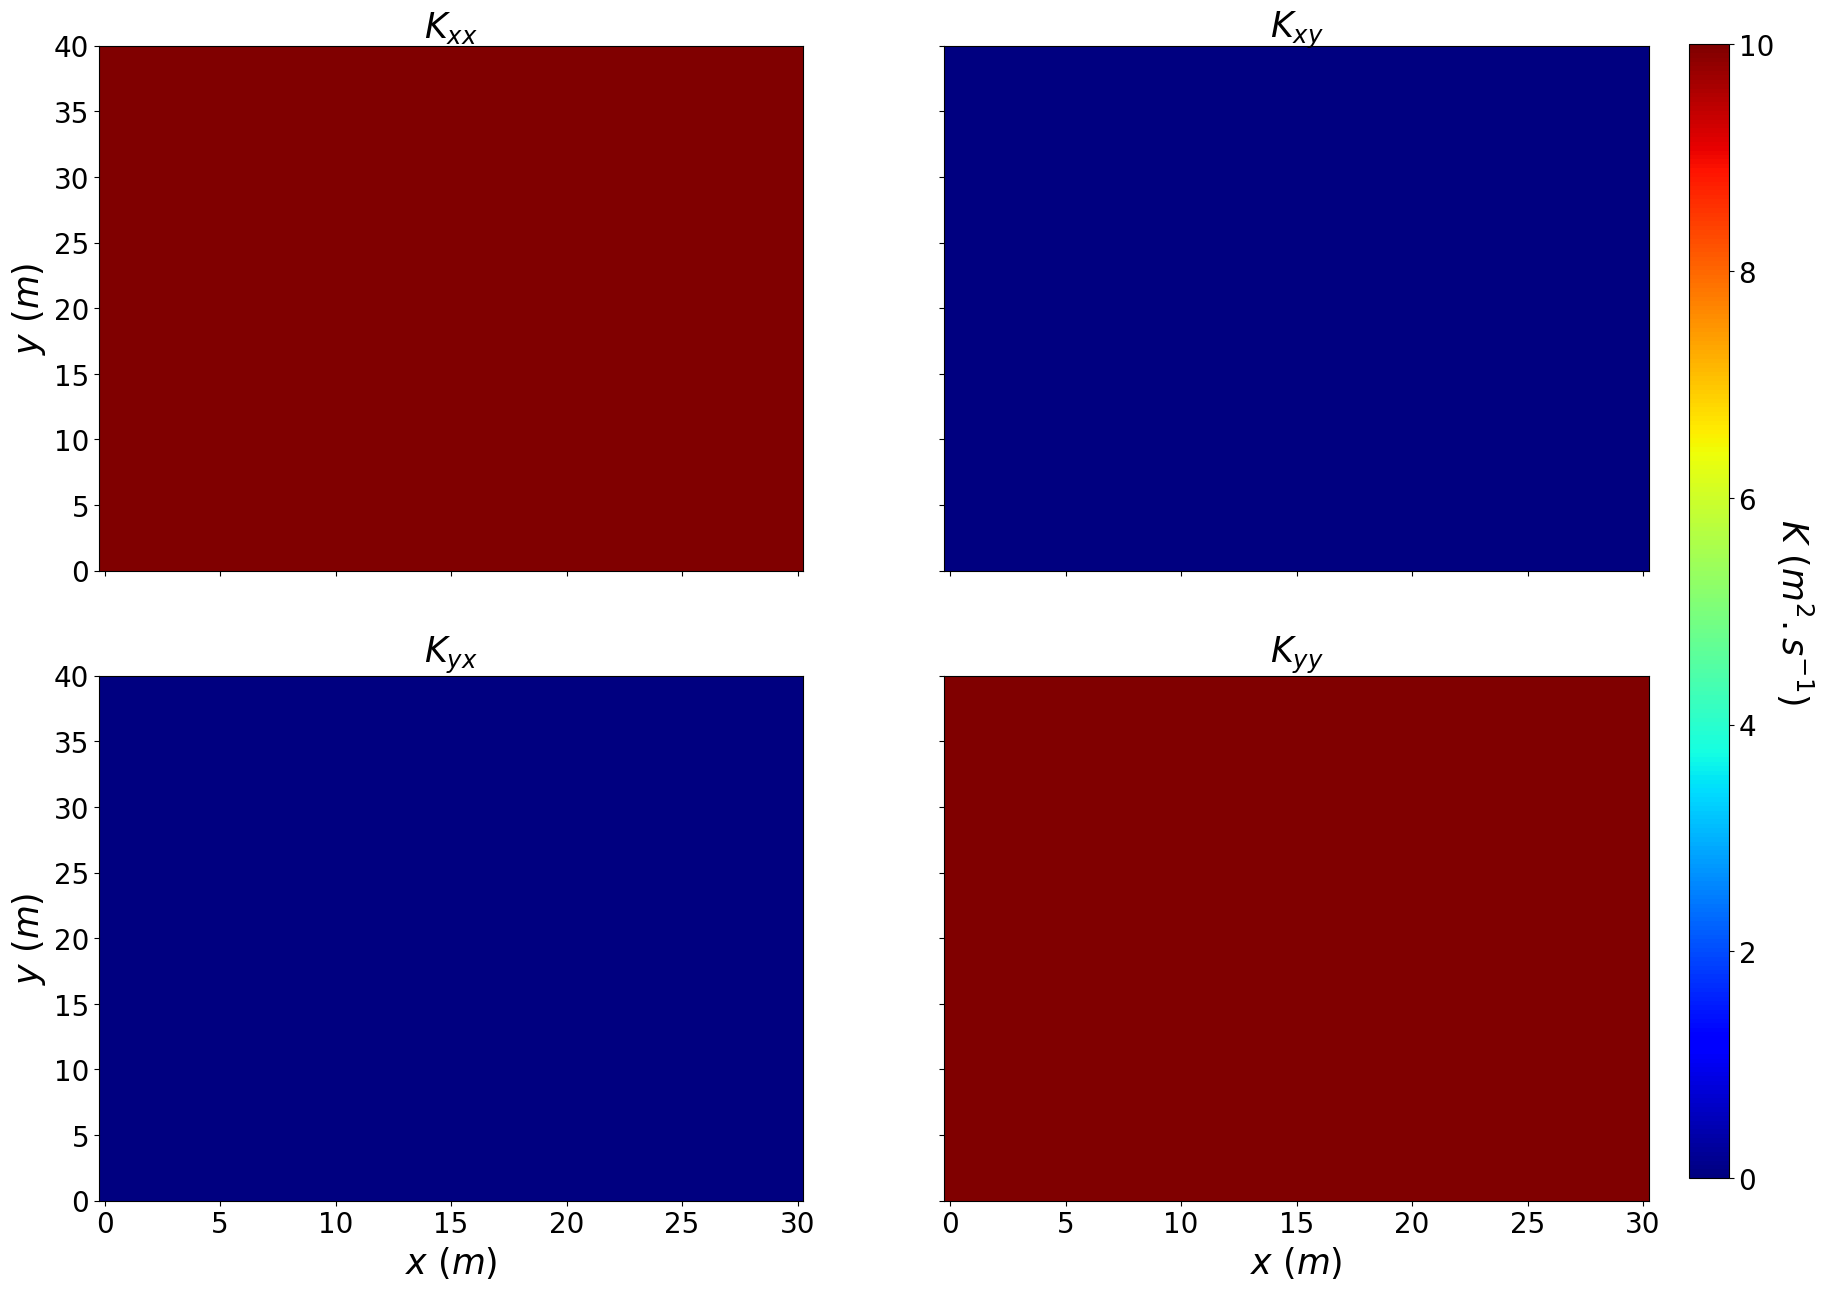

In [8]:
plot_diffusion_tensor(msh, K)

## Specifying the loss coefficient

The loss coefficient is here simply contained in a array of shape (nb cell in y axis, nb cell in x axis) that is the average loss coefficient over a cell and that the user should provide. 

In [9]:
loss_coeff = 0.01*np.ones((msh.y.size, msh.x.size))

Moreover, the user can plot the loss coefficient map using the `plot_colormap` [method](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/utils/plot_colormap.py) of the module `utils`.

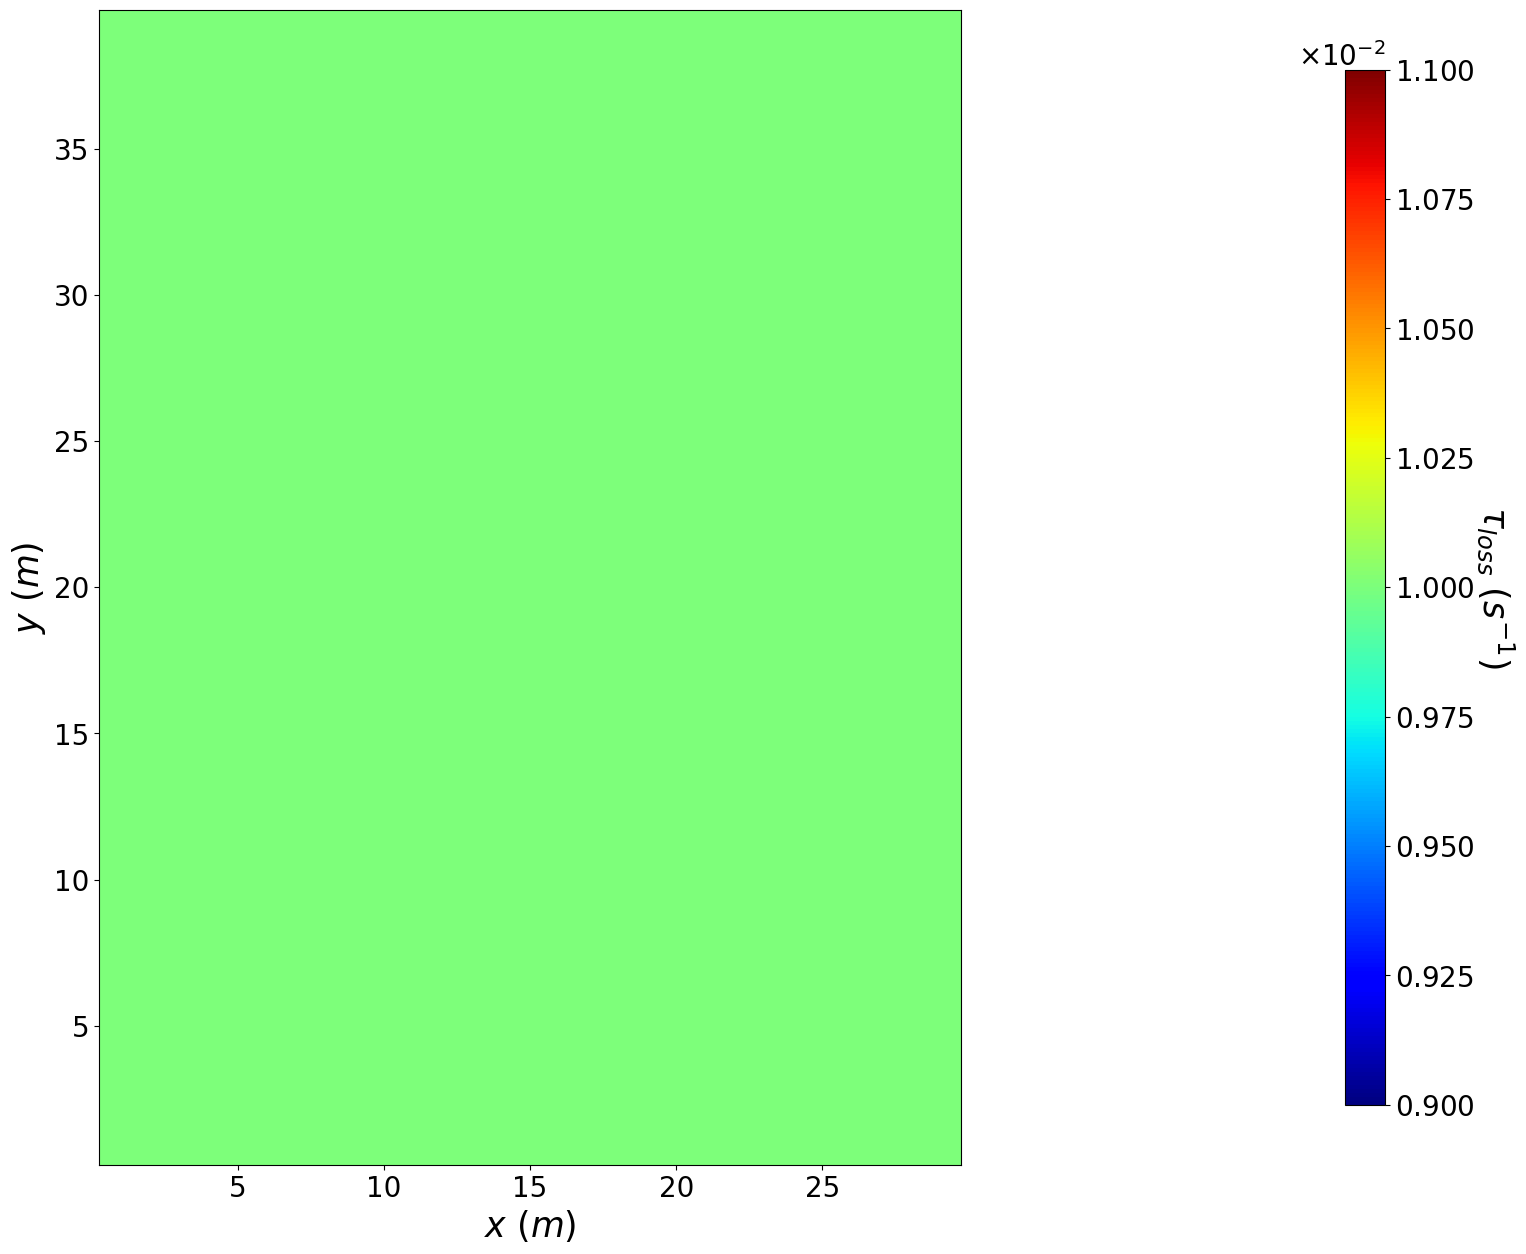

In [10]:
plot_colormap(msh,loss_coeff,'\\tau_{loss}', 's^{-1}', cmap="jet")#, save_path=path_plot

As mentionned earlier, the loss coefficient depends on the vegetation covering the ground. With this in mind, the [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/pheromone_dispersion/deposition_coeff.py) `deposition_coefficient` contains the method `deposition_coeff_from_land_occupation_data` that return the loss coefficient map given a file containing land occupation data and a dictionnary containing the loss coefficient depending on the land occupation.\
Let us note that the keyword of the columns containing the polygon and the land occupation classification of the land occupation data may vary depending on the format. However, the method can be easily modified to match a given format.

## Specifying the pheromone emission using the `source_term` submodule 

The last element of the pheromone propagation model is the source term that is the quantity of pheromone emitted by the pest insect that should be provided by the user when modelling the propagation of pheromone in the atmosphere. 
The source term is contained in an object of the `Source` class contained in the `source_term` [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/pheromone_dispersion/source_term.py).\
As for the wind field, one can provide stationnary source term and otherwise, the time array should be specified and between two time points contained in this array, the source term will be linearly interpolated.\
Thus, the user should provide an array containing the source term at each cells of the mesh that is of shape (nb cell in y axis, nb cell in x axis) if the source term is stationnary, and of shape (nb time point, nb cell in y axis, nb cell in x axis) otherwise.

In [11]:
amp = 0.5
xc = 6.
yc = 6.
r = 1.5# 2 # 
S_value = np.zeros((msh.t_array[::2].size, msh.y.size, msh.x.size))
xx, yy= np.meshgrid(msh.x, msh.y)
S_value[:, (xx-xc)**2 + (yy-yc)**2 < r**2] = amp

S = Source(msh, S_value, t=msh.t_array[::2])

Moreover, the user can plot the source term at a given time using the `plot_colormap` [method](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/utils/plot_colormap.py) of the module `utils`.

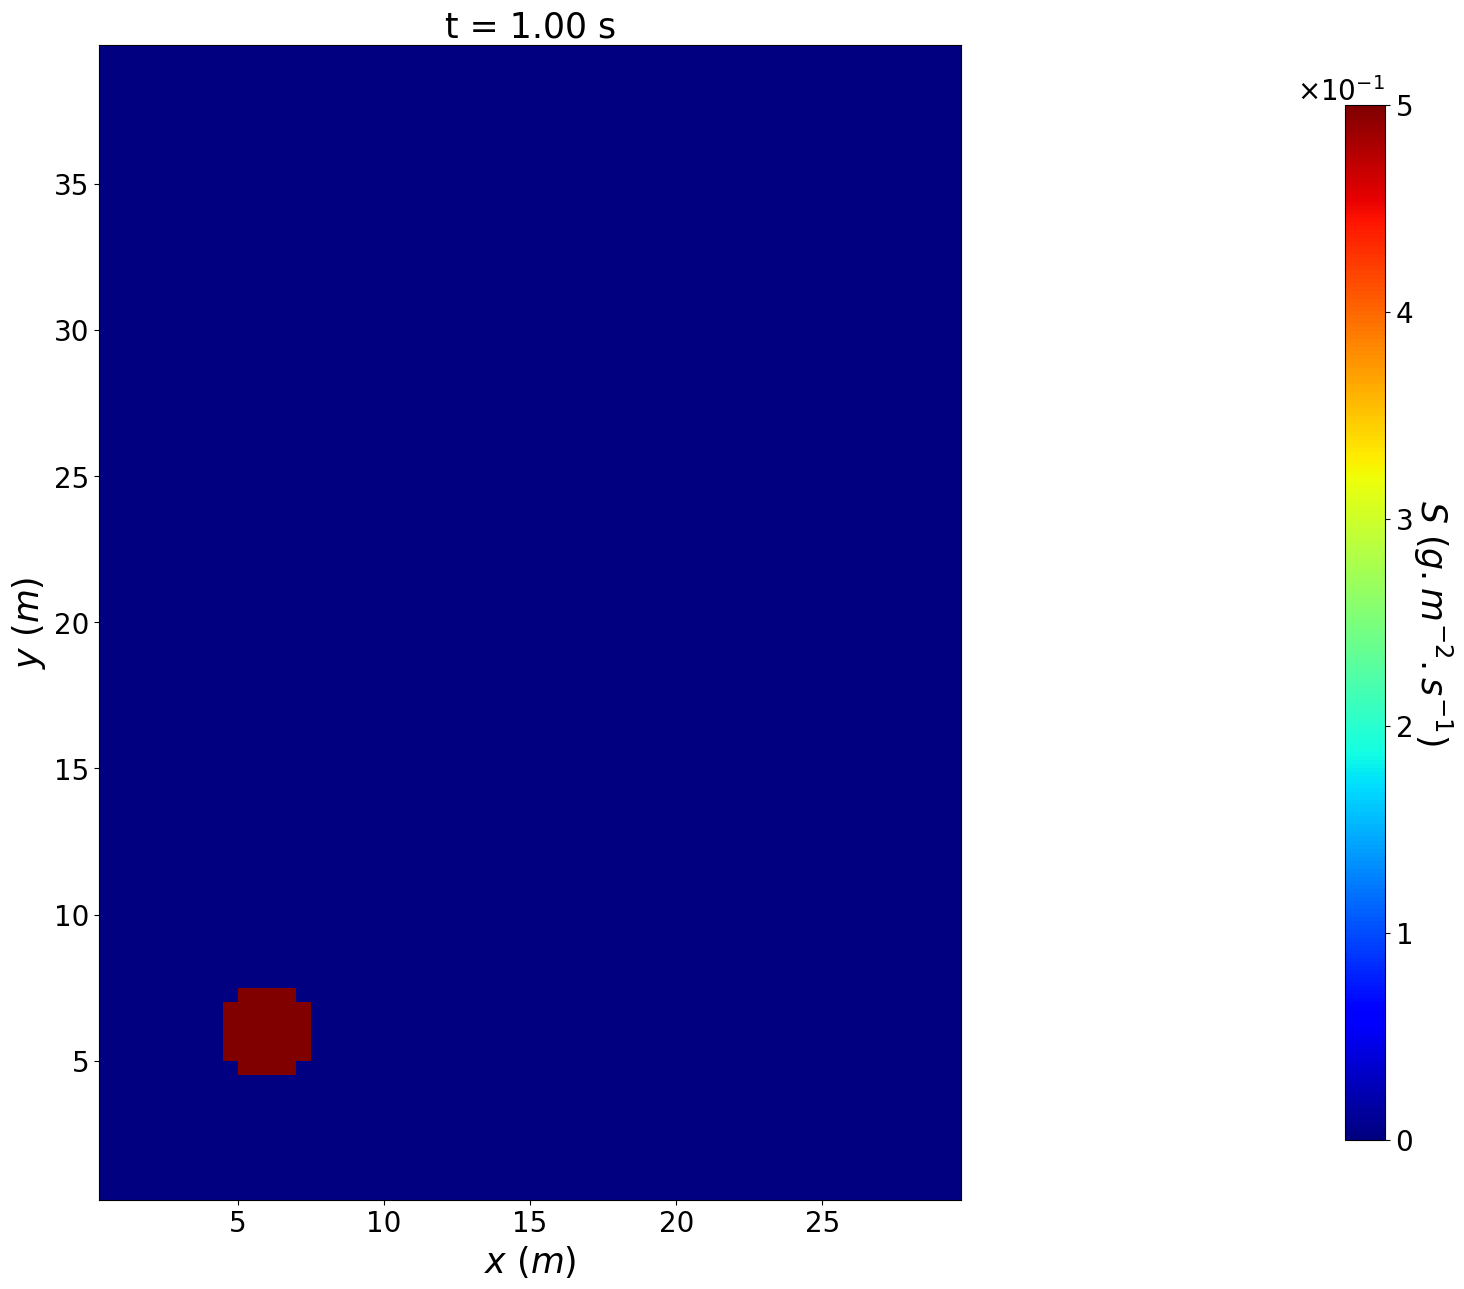

In [12]:
t_on = 1.
S.at_current_time(t_on)
plot_colormap(msh,S.value,'S', 'g.m^{-2}.s^{-1}', cmap="jet",title=f't = {"{:.2f}".format(t_on)} s')

As for the class `Velocity` and the class `DiffusionTensor`, the class `Source` contains the method `at_current_time` that enables to update all the attributes at the time given as input of the method.

## Specifying the pheromone propagation model and its solver using the `convection_diffusion_2D` submodule

The pheromone propagation model is contained in an object of the class `DiffusionConvectionReaction2DEquation` of the `convection_diffusion_2D` [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/pheromone_dispersion/convection_diffusion_2D.py).\
In addition to the wind field, diffusion tensor, loss coefficient and source term that have been specified above, the user can specify the type of time discretization (see more details below and in [this notebook](./test_numerical_scheme/test_EDP_model_direct.ipynb) on the numerical scheme) and the relative tolerance of the resolution of the linear system at each time step.

In [13]:
solver = 'implicit with stationnary matrix inversion'
tol = 1e-10
EDP = DiffusionConvectionReaction2DEquation(
    U, 
    K, 
    loss_coeff, 
    S, 
    msh, 
    tol_inversion=tol, 
    time_discretization=solver
)

Multiple solver types have been implemented in the class `DiffusionConvectionReaction2DEquation` and the associated keyword can be found in the attribute `implemented_solver_type`.

In [14]:
print(EDP.implemented_solver_type)

['implicit', 'semi-implicit', 'semi-implicit with matrix inversion', 'implicit with stationnary matrix inversion']


With the implicit and semi-implicit time discretization, the resolution of the linear system at each time step are based on resp. a GMRES algorithm and a conjugate gradient algorithm. 

With the time discretization with matrix inversion, the matrices of the linear system to solve are inverted once and for all and then, the resolution of the linear system at each time step is reduced to a matrix-vector product.\
In this case, the user should use the method `init_inverse_matrix` of the class `DiffusionConvectionReaction2DEquation`. With this method, the user specifies the path and name of the file containing the inverse matrix. If the inverse matrices have already been computed and stored in the specified file, then the method load the matrices. If the inverse matrices are not found in the folder, then the method computes and store them once and for all.\
This is particularly efficient when the wind is assumed stationnary and so the matrix to invert is the same at each time step. This case is implemented under the keyword `implicit with stationnary matrix inversion` and is used in this test case. 

In [15]:
fname = 'inv_matrix_implicit_solver'
EDP.init_inverse_matrix(path_to_matrix=path_data, matrix_file_name=fname)

=== Computation of the inverse of the matrix of the implicit part of the implicit with stationnary matrix inversion scheme ===
--- Computation at time t=  0 in  11.089861392974854  s


# Solving the PDE to model the pheromone propagation and plot the pheromone concentration

The pheromone propagation can be solved using the `solver` method.\
This method aims at computing the pheromone concentration on the whole domain and at time steps given a store rate, for instance a store rate of 10 will imply one time out of ten will be returned and saved. The user can use optional inputs to save the results in a given folder. 

In [16]:
if not (Path(path_output) / 'c_save.npy').exists():
    t_0 = time.time()
    store_rate = 10
    t_output, c_output = EDP.solver(save_flag=True, path_save=path_output, store_rate=store_rate)
    t_f = time.time()
    print("")
    print("--- resolution of the direct model in %s seconds ---" % (t_f - t_0) )
else: 
    print("--- the resolution has already been performed ---")
    c_output = np.load(Path(path_output) / f'c_save.npy')
    t_output = np.load(Path(path_output) / f't_save.npy')

t = 20.000 / 20.000 s
--- resolution of the direct model in 3.335312843322754 seconds ---


The resulting pheromone concentration map can easily be plotted at a given time using the `plot_colormap` [method](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/utils/plot_colormap.py) of the module `utils`.

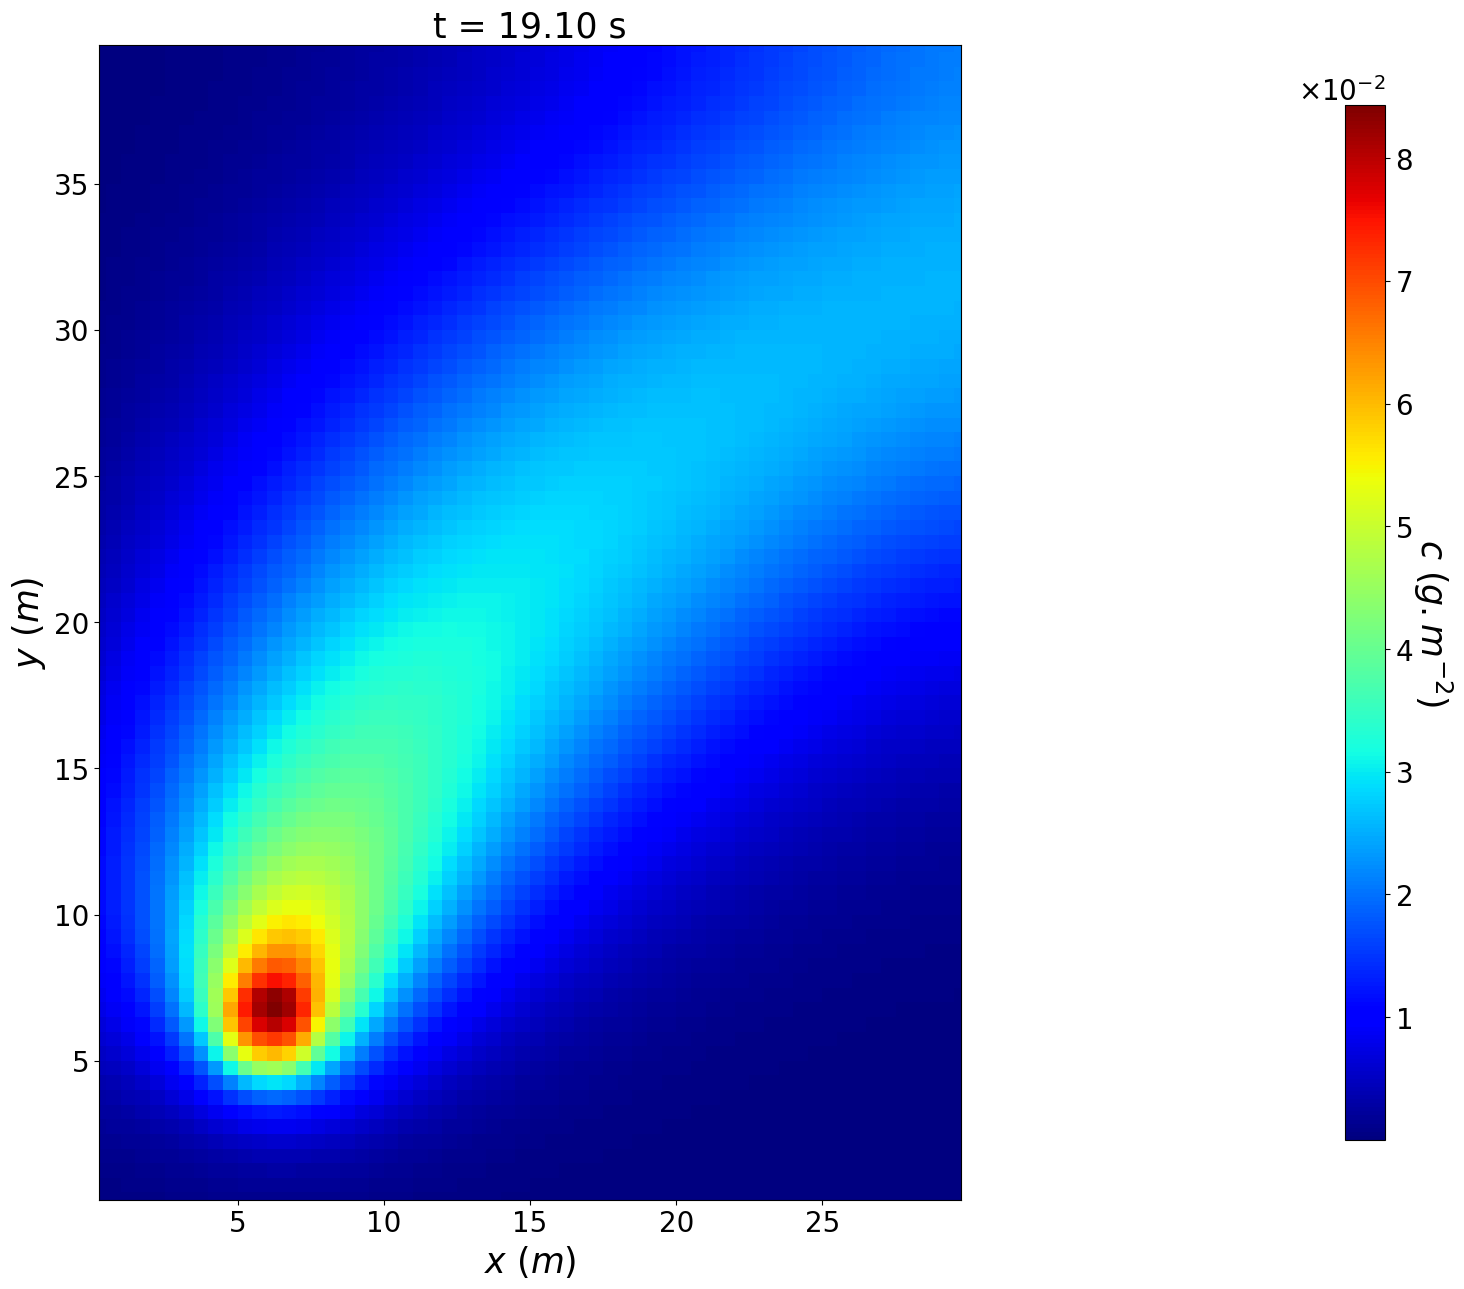

In [17]:
t_plot = 20.
i = np.argmin(np.abs(t_output-t_plot))
plot_colormap(msh,c_output[i,:,:],'c', 'g.m^{-2}', cmap="jet",title=f't = {"{:.2f}".format(t_output[i])} s')#, save_path=path_plot

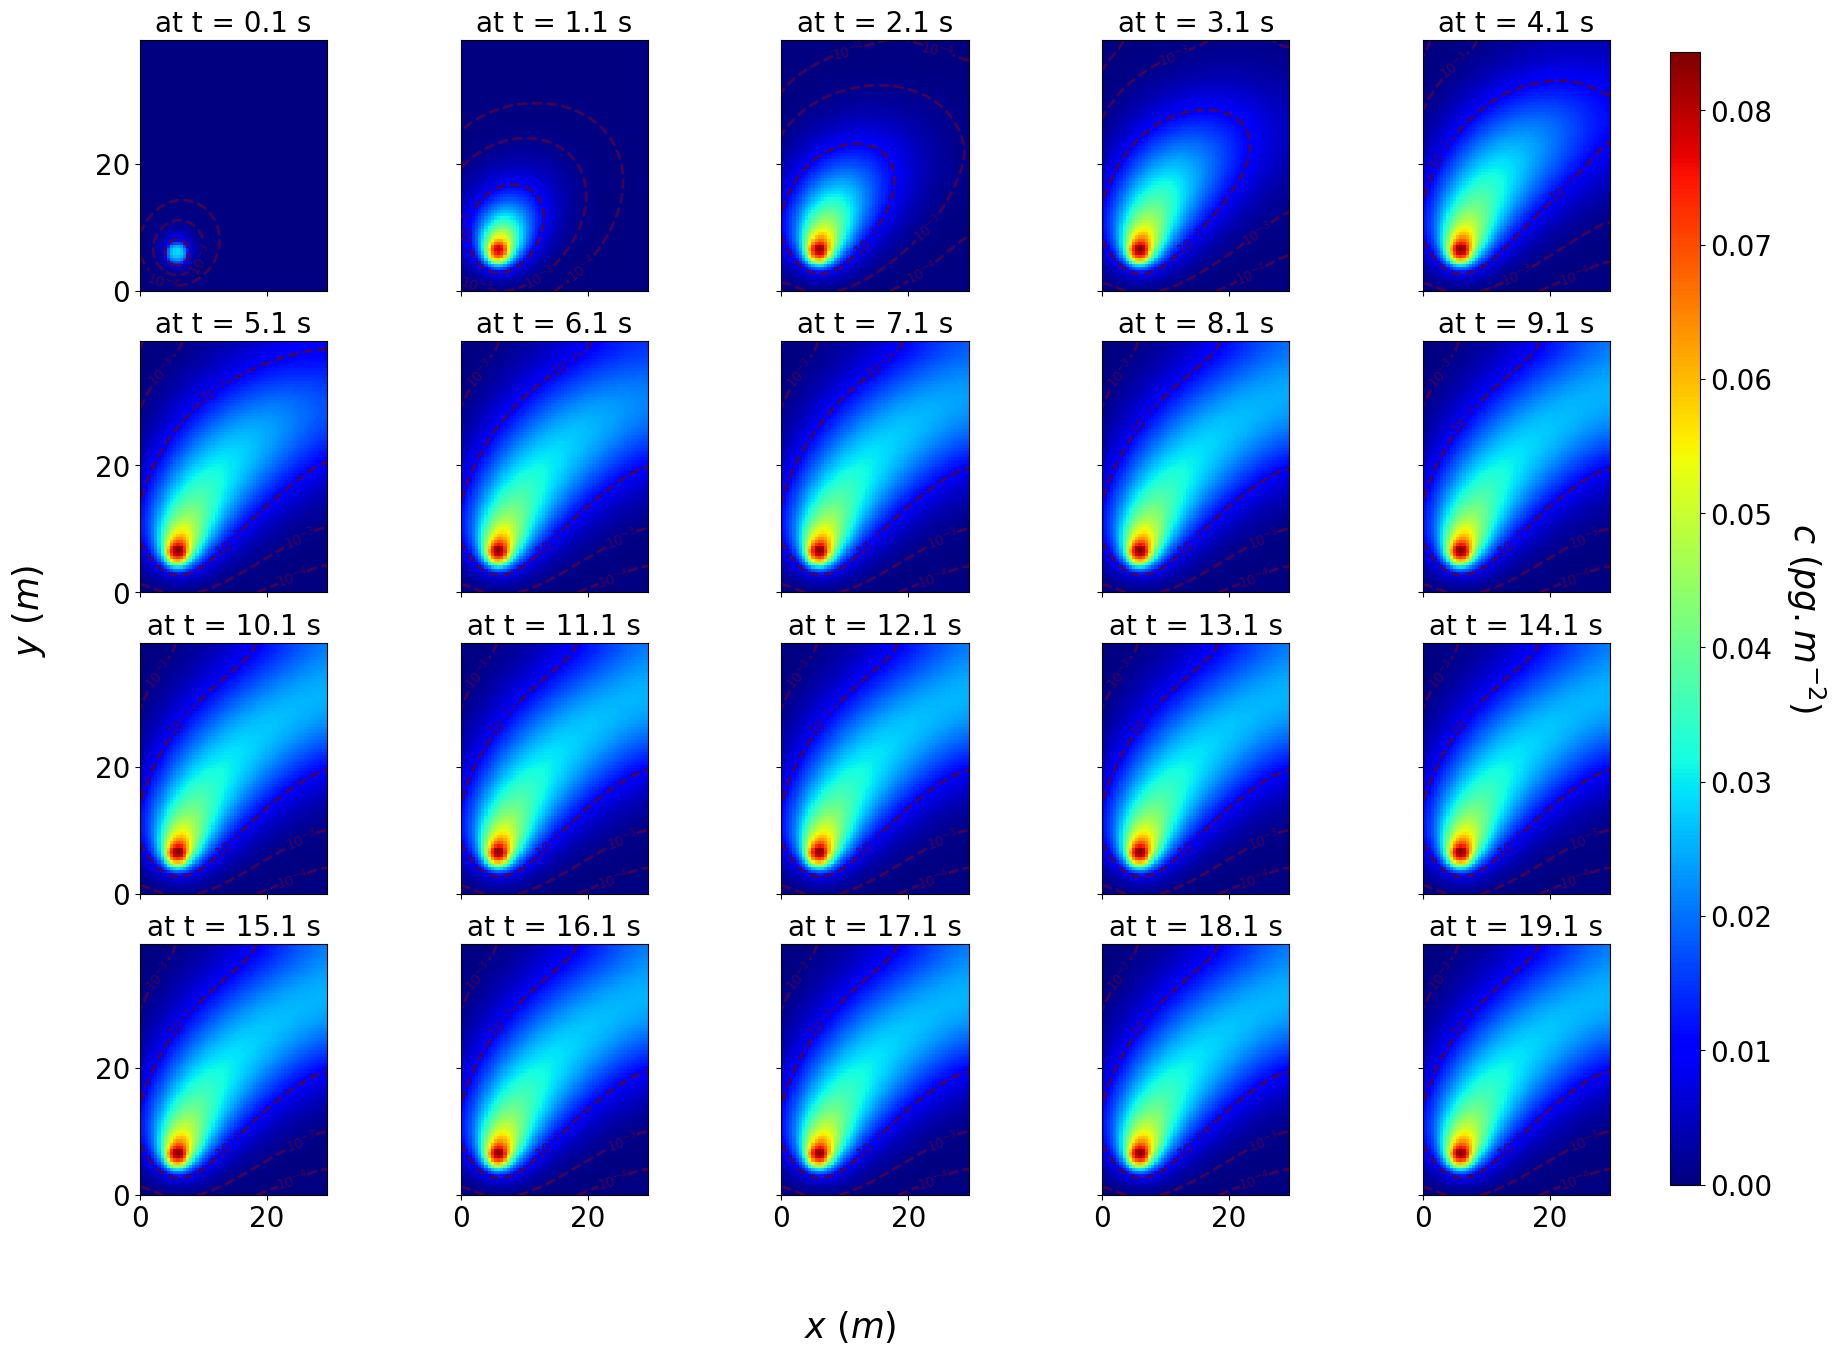

In [18]:
n_col = 5
n_ligne = t_output.size//n_col

fontsize=25
xv, yv = np.meshgrid(msh.x, msh.y, sparse=True, indexing="ij")
vmin = np.min(c_output)
vmax = np.max(c_output)
fig, axs = plt.subplots(n_ligne,n_col,figsize=(20,15), sharex=True, sharey=True)

for i, t in enumerate(t_output):

    l = i//n_col
    c = i%n_col
    title = f'at t = {"{:.1f}".format(t)} s'
    fmt = ticker.LogFormatterMathtext()
    fmt.create_dummy_axis()
    levels = [10**(i) for i in [-4,-3,-2,-1,0]]
    c_plot = c_output[i,:,:]
    contour = axs[l,c].contour(msh.x-np.min(msh.x), msh.y-np.min(msh.y), c_plot, linestyles='dashed', levels=levels, linewidths=2)
    axs[l,c].clabel(contour, inline=True, fontsize=10, fmt=fmt)
    pcmesh = axs[l,c].pcolormesh(xv[:, 0]-np.min(msh.x), yv[0, :]-np.min(msh.y), c_plot, cmap='jet', vmin=vmin, vmax=vmax)
    axs[l,c].set_aspect('equal', adjustable='box')
    axs[l,c].set_title(title, fontsize=fontsize - 5)
    axs[l,c].set_xticks([0,20,40])
    axs[l,c].set_yticks([0,20,40,60])
    axs[l,c].tick_params(labelsize=fontsize - 5)
    axs[l,c].set_xlim(0.,np.max(msh.x)-np.min(msh.x))
    axs[l,c].set_ylim(0.,np.max(msh.y)-np.min(msh.y))
    
fig.supxlabel('$x$ ($m$)', fontsize=fontsize)
fig.supylabel('$y$ ($m$)', fontsize=fontsize, x=0.08, y=0.5)
cbar_ax = fig.add_axes([0.91, 0.117, 0.015, 0.755])
cbar = fig.colorbar(pcmesh, cax=cbar_ax)
cbar_ax.tick_params(labelsize=fontsize - 5)
cbar.set_label('$c$ ($pg.m^{-2}$)', rotation=270, fontsize=fontsize, labelpad=40)
plt.show()

One can also plot multiple time step using the `plot_colormap_all_timestep` method and generate a gif using these plots and the [method](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/utils/generate_gif.py) `generate_gif` of the module `utils`.

In [19]:
path_plot_all_timestep = path_plot + '/plot_all_timestep'
if not os.path.isdir(Path(path_plot_all_timestep)):
    os.makedirs(Path(path_plot_all_timestep))
plot_colormap_all_timestep(msh,t_output,c_output,'c', 'g.m^{-2}', cmap="jet", save_path=path_plot_all_timestep)

 ite = 20 / 20

In [20]:
generate_gif(images_path=path_plot_all_timestep, save_path=path_plot, file_name='output_pheromone_propagation')

 100% : saving the gifg